# Random Forest

## Outline

- [Import IKEA Furniture Data-Set](#Import-IKEA-Furniture-Data-Set)
- [Create a Random Forest](#Create-a-Random-Forest)
    - [Create a First Version of a Random Forest](#Create-a-First-Version-of-the-Random-Forest)
    - [First Improvements of the Random Forest](#First-Improvements-of-the-Random-Forest)
    - [Final Version of the Random Forest](#Final-Version-of-the-Random-Forest)
    - [Further Investigations of the Random Forest Model](#Further-Investigations-of-the-Random-Forest-Model)
- [Conclusion](#Conclusion)

In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="white")

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

## Import IKEA Furniture Data-Set

In [2]:
# load IKEA_df
with open('Data/IKEA_df.p', 'rb') as df:
    IKEA_df = pickle.load(df)

IKEA_df.head(4)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,...,designer_len,size,unit,size_nounit,depth_median,depth_mean,height_mean,height_median,width_median,width_mean
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,"Bar table, in/outdoor",Nicholai Wiig Hansen,...,20,51x51 cm,cm,51x51,47.0,45.725926,97.571429,102.0,48.0,52.07027
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,Bar table,Francis Cayouette,...,17,140x80 cm,cm,140x80,47.0,45.725926,97.571429,102.0,48.0,52.07027
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,...,17,NaN,NaN,NaN,47.0,45.725926,97.571429,102.0,48.0,52.07027
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,True,Bar stool with backrest,Henrik Preutz,...,13,74 cm,cm,74,47.0,45.725926,97.571429,102.0,48.0,52.07027


In [3]:
# load learn_df
with open('Data/learn_df.p', 'rb') as df:
    learn_df = pickle.load(df)

In [4]:
# get labels
label = IKEA_df['category'].unique()
label = label.tolist()
print('labels:', label)

labels: ['Bar furniture', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards', 'Café furniture', 'Chairs', 'Chests of drawers & drawer units', "Children's furniture", 'Nursery furniture', 'Outdoor furniture', 'Room dividers', 'Sideboards, buffets & console tables', 'Sofas & armchairs', 'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes']


In [5]:
# get number of features that can be used as predictors
t = learn_df.drop(columns = ['category','category_num']).shape[1]
print('Overall, there are '+str(t)+' features.')

Overall, there are 9 features.


## Create a Random Forest
We first take look at an example calssifier, it is almost a standard random forest classifier apart from that we set min_samples_leaf= 5.

**Note**: the exact value of overall accuracy, accuracy in confusion matrix and even ranking of feature importance might slightly differ from the ones written in comments because of randomness in algorithm.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

### Create a First Version of a Random Forest

In [7]:
# split data into test and training dataset
X_train, X_test, y_train, y_test = train_test_split(learn_df.drop(columns = ['category','category_num']), \
                                                    learn_df['category_num'], random_state=1)

rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a = accuracy_score(y_test, y_pred)
# Note : this acuracy is not weighted by sample size!!! 
print('Overall acuracy of all category: ' +str(a))

Overall acuracy of all category: 0.7965367965367965


**Note** : this overall acuracy is not weighted by sample size , so even for a category with a small size the performance is totally trash, we still have an acceptable overall acuracy.

In [8]:
#check feature importance
feature_impo = pd.Series(data=rf_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

depth              0.295635
height             0.252658
name               0.218625
width              0.083165
price              0.058952
designer           0.054867
other_colors       0.020179
item_id            0.015917
sellable_online    0.000001
dtype: float64

Text(0.5, 1.0, 'Feature importance')

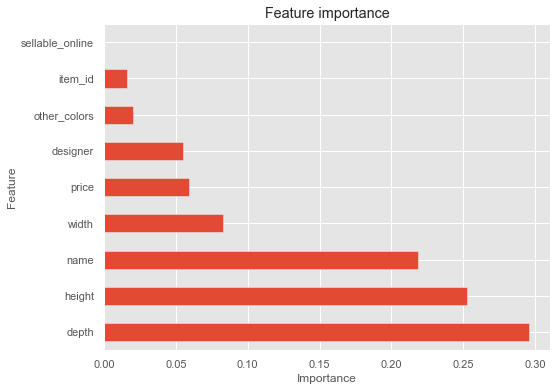

In [9]:
figip,axip = plt.subplots(1,1, figsize=(8,6))
feature_impo.plot(kind='barh', ax=axip)
axip.set_xlabel('Importance')
axip.set_ylabel('Feature')
axip.set_title('Feature importance')

Now lets check the confusion matrix to examine the acuracy for each category

In [10]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

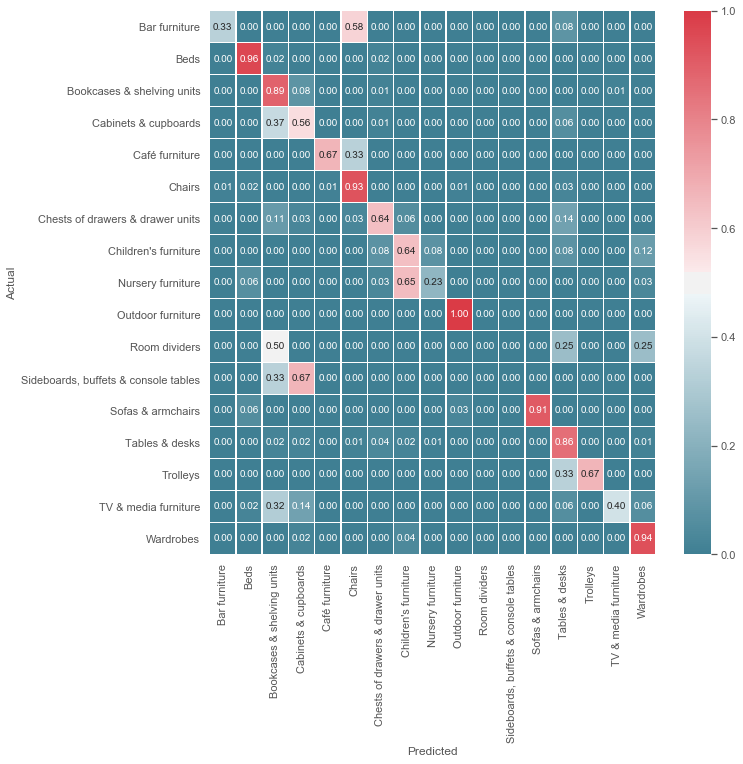

In [11]:
#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Random_Forest/RF_CM_1.png', bbox_inches = 'tight')

An analysis of this confusion matrix will be given later; toghether with next plot.

### First Improvements of the Random Forest
First improvement by further selection of the features by only keeping the important features.
From feature importance report we get that size data  play the  great role in prediction, as we asuumed before in feature analysis. In addition name of the items is also important. Lets see what happens if we just keep those 5 top features with importance  larger than around 5%. We remove the feature **sellable online**, **item_id** and **other_colors**.

In [12]:
# we need item_id and category in dataframe for other use, not for training
learn1 = ['item_id','height','depth','width','name','designer','category','category_num']
learn_df1 = learn_df[learn1]

In [13]:
# split the data into test and training data-set
X_train, X_test, y_train, y_test = train_test_split(learn_df1.drop(columns = ['item_id','category','category_num']), \
                                                    learn_df1['category_num'], random_state=1)
# create random forest
rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a = accuracy_score(y_test, y_pred)
print('Overall acuracy of all category: ' +str(a))

Overall acuracy of all category: 0.8203463203463204


The overall acuracy increased from about 80% to 82%

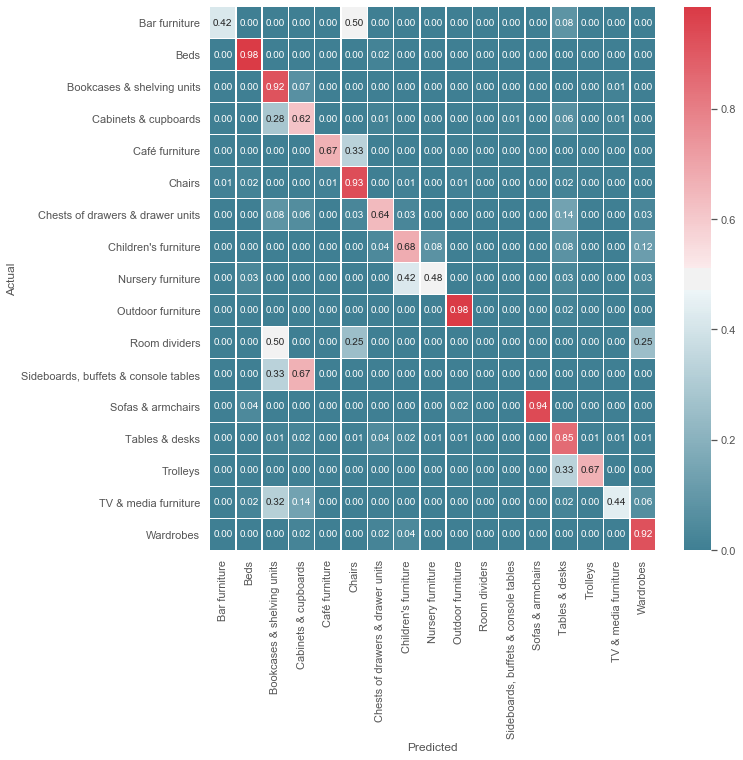

In [14]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Random_Forest/RF_CM_2.png', bbox_inches = 'tight')

Compare the both confusion matrix we get that through feature selection,  we increase the overall accuracy at about1%  in the way that the accuracy for category Nursury furniture have been significantly increased by 10% respectly. And it is clear that the category with the worst performance: Room diveider with 0%, Sideboards & console tables with 0%, then Bar furniture 42%. Those are exactly the category with smallest sample size in whole dataset. As we mentioned above we can replicate  those samples to make it to a  ralative balanced multi-class classification task. The category TV & media furniture perform also not good, 30% TV& medianfurnitures have been predicted as Book cases & shelving unit. Considering the feature importance and boxplot of height and depth, we find that those two category have really simillar distribution shown in boxplot of those top 2 features.No wonder then.To our supprise, category Trolleys ,of which samples size is just 28, has the outstanding performance. We did not find the obvious clue from  its size  and price. We take look at the data set and find  the option for its name and designer is restricted and this might be the reason.  

### Final Version of the Random Forest
Improve the results by replicating the samples for the categories with a small sample size. This is the case for the following categories: **Room dividers** and **Sideboards, buffets & console tables**.
The categories with small sample sizes in the dataset are replicated in order to make this multi class classification task be relativly balanced. As the results will prove, the accuracy of the model can be increased significantly by doing so.

In [15]:
#recall the sample size of each category
size_df = learn_df1.groupby('category').size().reset_index(name='size')
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


In [16]:
# careful here the order of the labels somehow changed compared to the list 'label' above. The order of TV & median furniture
# tables& dsks and trollyes somehow echanged as can be seen below . Thus, we cannot use the list label to display the correct order of 
# column names in this section.
label1 =size_df['category'].tolist()
if label != label1:
    print('label does not equal label1. In the following, therefore label1 will be used.')

label does not equal label1. In the following, therefore label1 will be used.


In [17]:
label_size = size_df['size'].tolist()
label_size

[47, 208, 548, 292, 26, 481, 125, 124, 97, 216, 13, 23, 428, 190, 612, 28, 236]

In [18]:
learn_df2 = learn_df1.copy() 

In [19]:
# using label1 instead of label!
#print(learn_df2.shape[0])
for k in range(17):
    temp_df = learn_df1[learn_df1['category'].str.contains(label1[k])] 
    #print('original size' + str(temp_df.shape[0]))
    #print('label_size' +str(label_size[k]))
    tt = round(max(label_size)/label_size[k]) -1
    #print('to replicate' + str(tt))
    if tt > 0:
        temp_df1 = pd.concat([temp_df]*tt, ignore_index=True)
        #print('df_repl size' +str(temp_df1.shape[0]))
        learn_df2 = pd.concat([learn_df2, temp_df1] , ignore_index=True)
        #print(learn_df2.shape[0])

In [20]:
# old dataset imbalanced
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


In [21]:
#new relative balanced data set with duplicated samples
size_df2 = learn_df2.groupby('category').size().reset_index(name='size')
size_df2

,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


Now that the data-set has been modified, the samples are relatively balanced - even though there are many duplicated samples for the categories that only had very few samples before.
Thus in a next step, the final version of the random forest can be created. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(learn_df2.drop(columns = ['item_id','category','category_num']), \
                                                    learn_df2['category_num'], random_state=1)
rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a = accuracy_score(y_test, y_pred)
print('Overall acuracy of all category: ' +str(a))

Overall acuracy of all category: 0.88928430209569


Despite the replicated samples, we were able to increase the overall accuracy from about 82% to 89%.

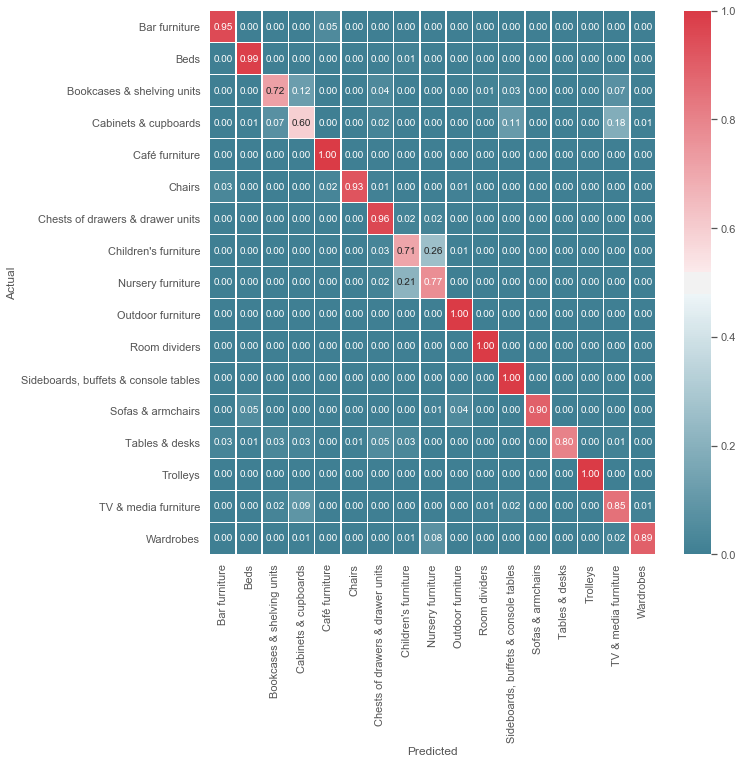

In [23]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/Random_Forest/RF_CM_3.png', bbox_inches = 'tight')

Now we have an almost perfect diagonal matrix we desired. Through repeating samples to make size of each category  balanced,  the acuracy of prediction for Bar funiture has been increased from 42% to 95% ,  for Room dividers from 0% to 100%,  for Sideboards, buffets & console rable from 0% to 100% etc. It is still hard for the algorithm to distinguish nursery furniture from children furniture.The reason is clear that consering two the immportant features: height and depth, the distribution are almost the same in the box plot.  

In [24]:
feature_impo = pd.Series(data=rf_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

name        0.297578
depth       0.277063
height      0.246869
width       0.101972
designer    0.076518
dtype: float64

And now with replicated samles in data set , the feature name(former) becomes the most important feature, followed by height (former top1) and depth(former top2).

### Further Investigations of the Random Forest Model

 Now we try out different parameter settings to see if we can get better predictions. After trail and error we keep the following parameter sets to show the impact of those parameters. Best minimum samples in leaf  is  1 (we set 5 before), if increase the size the overall predictions accuracy goes down. Normally the acurracy increase with the size of forest until  reaching certain threshold and the accuracy become stable. In total those parameters just influence the overall acuracy less than 0.01, and the best overall accuracy witih random forest is about 90.27% for minimum_samples_leaf =1, n_tree = 400. Here we won't check the single confusion matrix, since the dataset is now balanced w.r.t sample size of each category. 

In [25]:
def RandomForest(n_tree, min_leaf, learn_df):
    
    X_train, X_test, y_train, y_test = train_test_split(learn_df.drop(columns = ['category_num','category','item_id']), \
                                                        learn_df['category_num'], random_state=1)
    print('==================='+'Process for Param_'+str(i)+'_'+ str(l)+'===================')
    start_time = time.time()
    rf =  RandomForestClassifier(n_estimators = n_tree,criterion = 'gini', min_samples_leaf = min_leaf,random_state =1)
    rf.fit(X_train,y_train)
    y_pred =  rf.predict(X_test)
    end_time = time.time()
    print('time consumption: '+ str(end_time - start_time))
    # overall accuracy
    a = accuracy_score(y_test, y_pred)
    print('Overall accuracy: ' +str(a))
# uncomment all below to check the confusion matrix for each loop
#     # confusion matrix   
#     m =  confusion_matrix(y_test, y_pred)
#     #calculate total number of samples of each category in X_test
#     m_sum = m.sum(axis = 1)
#     m1 = np.zeros((17,17))
#     for k in range(17):
#          m1[k,:] = m[k,:]/m_sum[k]
#     m_df = pd.DataFrame(m1,index = label, columns=label)
#     #plot confusion matrix
#     fig, ax = plt.subplots(figsize=(10,10))
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     sns.heatmap(m_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('Actual')
#     ax.figure.savefig('Figures/RF_CM_Param_'+str(i)+ '_' + str(l) +'_'+str(round(a,3))+'_.jpg',bbox_inches = 'tight')

In [26]:
# number of the  decision tree in forest
n_tree = [20,50,100,200,400,600]
# those two criterion almost make no difference to overall acuracy,  too complicated to examine their impact on each category
# so just use the default gini index
#crit = ['gini','entropy']
# minimum number of samples in the leaf (end node)
min_leaf = [1,3,5,7]

In [27]:
for i in range(len(n_tree)):
        for l in range(len(min_leaf)):
            RandomForest(n_tree[i], min_leaf[l],learn_df2)

===================Process for Param_0_0===================
time consumption: 0.2823219299316406
Overall acuracy: 0.8983788058521155
===================Process for Param_0_1===================
time consumption: 0.19128704071044922
Overall acuracy: 0.8952155001977066
===================Process for Param_0_2===================
time consumption: 0.17382597923278809
Overall acuracy: 0.8908659549228944
===================Process for Param_0_3===================
time consumption: 0.1816709041595459
Overall acuracy: 0.8805852115460656
===================Process for Param_1_0===================
time consumption: 0.4586911201477051
Overall acuracy: 0.9023329379201266
===================Process for Param_1_1===================
time consumption: 0.49300479888916016
Overall acuracy: 0.8940292605773033
===================Process for Param_1_2===================
time consumption: 0.460590124130249
Overall acuracy: 0.8916567813364966
===================Process for Param_1_3===================
time co

## Conclusion